In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML, Image
from ipywidgets import interact,Dropdown,IntSlider,FloatRangeSlider, FloatSlider, RadioButtons
rc('animation', html='html5')

In [3]:
cd /home/xupeng/projects/synapse/

/home/xupeng/projects/synapse


## metrics  synaptic_partners_fscore
- 看起来只需要test文件的annotation，和GT的annotation与neuron_id即可
- 这个annotaion是什么？ neuron_id  pre 和post location

## 计算fscore步骤
- cost_matrix 步骤:
    - pre_post_locations 获得pre和post的location，可以考虑offset的shift情况
       可以获得rec和gt的location
    - pre_post_labels 获得pre和post的segmentation？作为rec_labels  segmentation[pre]  得到该坐标点像素值,用于后续比较是否来自同一个segment
    - 建立cost矩阵，以rec和gt中location数量比较多的一个作为边长  初始值 2*matching_threshold
    - 接下来用cost函数计算，对于两两的rec和gt，输入rec_locations[i], gt_locations[j], rec_labels[i], gt_labels[j], matching_threshold
    - 在cost函数中，先设置max_cost = 2*matching_threshold，首先如果labels1 != labels2(rec_labels[i], gt_labels[j]),由pre_post_labels可知说明的是rec和gt不来自同一个segmentation（neuron），先return max_cost
    - cost函数继续，用np.linalg.norm计算pre和post各自的二范数，即距离，如果其中任意一个比thres大，也return max_cost。最终cost函数返回pre和post的距离的均值。即如果wrong partener(rec和gt不在一个seg)，或者FP：超过了阈值，如果都没有，就返回pre和post距离的均值
    - 回到cost_matrix函数中，如果距离小于阈值，给potential pair的count加上1 经过循环，cost_matrix填满了数，但是循环是rec_locations，gt_locations，没有遍历到的点自动为max_cost
- match using Hungarian method
>All detected pairs that have both annotations inside the matching areas of a ground truth pair are considered potential matches. Of all potential matches, we find true matches by solving an assignment problem minimizing the Euclidean distance. Unmatched detected pairs are considered FP, unmatched ground truth pairs FN. The final score is the F1-score of the FPs and FNs.

    - 用linear_sum_assignment(costs - np.amax(costs) - 1)  np.amax(costs)基本应该是max_cost(2*matching_threshold)
        - scpiy的linear_sum_assignment可以解决任务分配问题
        let X be a boolean matrix where X[i,j] =1 if row i is assigned to column j. Then the optimal assignment has cost $$min \sum_i \sum_j C_{ij}X_{ij}$$，即找到所有配对的最小欧式距离，返回两组数，分别是行和对应的列号。这样就找到了所有的可能配对的基于距离的最佳配对
    - 留下这些最佳配对中小于阈值的配对。


- unmatched in rec = FP，模型检测的所有配对个数减去这些配对的个数是FP的数量，
- unmatched in gt = FN，GT所有配对个数减去这些配对的个数是FN的数量
- all ground truth elements - FN = TP
- 接下来就可以计算fscore, precision, recall, fp, fn, filtered_matches等值
        

In [73]:
scipy.optimize.linear_sum_assignment(np.random.normal(5,10,100).reshape(10,10))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5, 7, 4, 0, 2, 9, 1, 8, 6, 3]))

In [4]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def synaptic_partners_fscore(rec_annotations, gt_annotations, gt_segmentation, matching_threshold = 400, all_stats = False):
    """Compute the f-score of the found synaptic partners.
    Parameters
    ----------
    rec_annotations: Annotations, containing found synaptic partners
    gt_annotations: Annotations, containing ground truth synaptic partners
    gt_segmentation: Volume, ground truth neuron segmentation
    matching_threshold: float, world units
        Euclidean distance threshold to consider two annotations a potential
        match. Annotations that are `matching_threshold` or more untis apart
        from each other are not considered as potential matches.
    all_stats: boolean, optional
        Whether to also return precision, recall, FP, FN, and matches as a 6-tuple with f-score
    Returns
    -------
    fscore: float
        The f-score of the found synaptic partners.
    precision: float, optional
    recall: float, optional
    fp: int, optional
    fn: int, optional
    filtered_matches: list of tuples, optional
        The indices of the matches with matching costs.
    """

    # get cost matrix
    costs = cost_matrix(rec_annotations, gt_annotations, gt_segmentation, matching_threshold)

    # match using Hungarian method
    print ("Finding cost-minimal matches...")
    matches = linear_sum_assignment(costs - np.amax(costs) - 1)
    matches = zip(matches[0], matches[1])  # scipy returns matches as numpy arrays

    filtered_matches = [ (i,j, costs[i][j]) for (i,j) in matches if costs[i][j] <= matching_threshold ]
    print (str(len(filtered_matches)) + " matches found")

    # unmatched in rec = FP
    fp = len(rec_annotations.pre_post_partners) - len(filtered_matches)

    # unmatched in gt = FN
    fn = len(gt_annotations.pre_post_partners) - len(filtered_matches)

    # all ground truth elements - FN = TP
    tp = len(gt_annotations.pre_post_partners) - fn

    precision = float(tp)/(tp + fp)
    recall = float(tp)/(tp + fn)
    fscore = 2.0*precision*recall/(precision + recall)

    if all_stats:
        return (fscore, precision, recall, fp, fn, filtered_matches)
    else:
        return fscore

def cost_matrix(rec, gt, gt_segmentation, matching_threshold):

    print ("Computing matching costs...")

    rec_locations = pre_post_locations(rec, gt_segmentation)
    gt_locations = pre_post_locations(gt, gt_segmentation)

    rec_labels = pre_post_labels(rec_locations, gt_segmentation)
    gt_labels = pre_post_labels(gt_locations, gt_segmentation)

    size = max(len(rec_locations), len(gt_locations))
    costs = np.zeros((size, size), dtype=np.float)
    costs[:] = 2*matching_threshold
    num_potential_matches = 0
    for i in range(len(rec_locations)):
        for j in range(len(gt_locations)):
            c = cost(rec_locations[i], gt_locations[j], rec_labels[i], gt_labels[j], matching_threshold)
            costs[i,j] = c
            if c <= matching_threshold:
                num_potential_matches += 1

    print (str(num_potential_matches) + " potential matches found")

    return costs

def pre_post_locations(annotations, gt_segmentation):
    """Get the locations of the annotations relative to the ground truth offset."""

    locations = annotations.locations()
    shift = sub(annotations.offset, gt_segmentation.offset)

    return [
        (add(annotations.get_annotation(pre_id)[1], shift), add(annotations.get_annotation(post_id)[1], shift)) for (pre_id, post_id) in annotations.pre_post_partners
    ]

def pre_post_labels(locations, segmentation):

    return [ (segmentation[pre], segmentation[post]) for (pre, post) in locations ]


def cost(pre_post_location1, pre_post_location2, labels1, labels2, matching_threshold):

    max_cost = 2*matching_threshold

    # pairs do not link the same segments
    if labels1 != labels2:
        return max_cost

    pre_dist = distance(pre_post_location1[0], pre_post_location2[0])
    post_dist = distance(pre_post_location1[1], pre_post_location2[1])

    if pre_dist > matching_threshold or post_dist > matching_threshold:
        return max_cost

    return 0.5*(pre_dist + post_dist)

def distance(a, b):
    return np.linalg.norm(np.array(list(a))-np.array(list(b)))

def add(a, b):
    return tuple([a[d] + b[d] for d in range(len(b))])

def sub(a, b):
    return tuple([a[d] - b[d] for d in range(len(b))])

In [65]:
np.linalg.norm(np.array([3,4]))

5.0

In [5]:
#from synaptic_partners import synaptic_partners_fscore

class SynapticPartners:

    def __init__(self, matching_threshold = 400):

        self.matching_threshold = matching_threshold

    def fscore(self, rec_annotations, gt_annotations, gt_segmentation, all_stats = False):

        return synaptic_partners_fscore(rec_annotations, gt_annotations, gt_segmentation, self.matching_threshold, all_stats)


In [6]:
synaptic_partners_evaluation = SynapticPartners()

### 查看test是什么东西
test = CremiFile('test.hdf', 'r')
truth = CremiFile('groundtruth.hdf', 'r')

In [11]:
testcremi = CremiFile('data/public/sample_A+_padded_20160601.hdf', 'r')
truth = CremiFile('data/public/sample_A_padded_20160501.hdf', 'r')

In [29]:
testcremi.read_annotations()

In [30]:
truth.read_neuron_ids()

##### Fscore算法
- 看起来只需要test文件的annotation，和GT的annotation与neuron_id即可？！
- annotation是presynaptic_site？
- 相关代码：
    - Annotations()  set_pre_post_partners(self, pre_id, post_id) annotation class读取，存储所有annotation相关数据
    尤其是id，location
    read_neuron_ids 读取neuron id /volumes/labels/neuron_ids
    cost_matrix 需要计算cost matrix 用到的还是上面的东西加上threshold
    pre_post_locations  并且用它的结果得到pre_post_labels

In [113]:
annotations

In [114]:
fscore = synaptic_partners_evaluation.fscore(annotations,annotations, truth.read_neuron_ids())


Computing matching costs...


IndexError: location (-1488.0, -3585.0, -3582.0) does not lie inside volume

In [32]:
fscore = synaptic_partners_evaluation.fscore(testcremi.read_annotations(), truth.read_annotations(), truth.read_neuron_ids())


Computing matching costs...
0 potential matches found
Finding cost-minimal matches...
0 matches found


ZeroDivisionError: float division by zero

### CremiFile class
- nee Annotations, Volume

In [8]:
class Annotations:

    def __init__(self, offset = (0.0, 0.0, 0.0)):

        self.__types = {}
        self.__locations = {}
        self.comments = {}
        self.pre_post_partners = []
        self.offset = offset

    def __check(self, id):
        if not id in self.__types.keys():
            raise "there is no annotation with id " + str(id)

    def add_annotation(self, id, type, location):
        """Add a new annotation.
        Parameters
        ----------
            id: int
                The ID of the new annotation.
            type: string
                A string denoting the type of the annotation. Use 
                "presynaptic_site" or "postsynaptic_site" for pre- and 
                post-synaptic annotations, respectively.
            location: tuple, float
                The location of the annotation, relative to the offset.
        """

        self.__types[id] = type.encode('utf8')
        self.__locations[id] = location

    def add_comment(self, id, comment):
        """Add a comment to an annotation.
        """

        self.__check(id)
        self.comments[id] = comment.encode('utf8')

    def set_pre_post_partners(self, pre_id, post_id):
        """Mark two annotations as pre- and post-synaptic partners.
        """

        self.__check(pre_id)
        self.__check(post_id)
        self.pre_post_partners.append((pre_id, post_id))

    def ids(self):
        """Get the ids of all annotations.
        """

        return self.__types.keys()

    def types(self):
        """Get the types of all annotations.
        """

        return self.__types.values()

    def locations(self):
        """Get the locations of all annotations. Locations are in world units, 
        relative to the offset.
        """

        return self.__locations.values()

    def get_annotation(self, id):
        """Get the type and location of an annotation by its id.
        """

        self.__check(id)
        return (self.__types[id], self.__locations[id])
class Volume:

    def __init__(self, data, resolution = (1.0, 1.0, 1.0), offset = (0.0, 0.0, 0.0), comment = ""):
        self.data = data
        self.resolution = resolution
        self.offset = offset
        self.comment = comment

    def __getitem__(self, location):
        """Get the closest value of this volume to the given location. The 
        location is in world units, relative to the volumes offset.
        This method takes into account the resolution of the volume. An 
        IndexError exception is raised if the location is not contained in this 
        volume.
        To access the raw pixel values, use the `data` attribute.
        """

        i = tuple([ round(location[d]/self.resolution[d]) for d in range(len(location)) ])

        if min(i) >= 0:
            try:
                return self.data[i]
            except IndexError as e:
                raise IndexError("location " + str(location) + " does not lie inside volume: " + str(e))

        raise IndexError("location " + str(location) + " does not lie inside volume")

    def __setitem__(self, location, value):
        """Set the closest value of this volume to the given location. The 
        location is in world units, relative to the volumes offset.
        This method takes into account the resolution of the volume. An 
        IndexError exception is raised if the location is not contained in this 
        volume.
        To access the raw pixel values, use the `data` attribute.
        """

        i = tuple([ round(location[d]/self.resolution[d]) for d in range(len(location)) ])

        if min(i) >= 0:
            try:
                self.data[i] = value
                return
            except IndexError as e:
                raise IndexError("location " + str(location) + " does not lie inside volume: " + str(e))

        raise IndexError("location " + str(location) + " does not lie inside volume")

In [10]:
class CremiFile(object):

    def __init__(self, filename, mode):

        self.h5file = h5py.File(filename, mode)

        if mode == "w" or mode == "a":
            self.h5file["/"].attrs["file_format"] = "0.2"

    def __create_group(self, group):

        path = "/"
        for d in group.split("/"):
            path += d + "/"
            try:
                self.h5file.create_group(path)
            except ValueError:
                pass

    def __create_dataset(self, path, data, dtype, compression = None):
        """Wrapper around h5py's create_dataset. Creates the group, if not 
        existing. Deletes a previous dataset, if existing and not compatible. 
        Otherwise, replaces the dataset.
        """

        group = "/".join(path.split("/")[:-1])
        ds_name = path.split("/")[-1]

        self.__create_group(group)

        if ds_name in self.h5file[group]:

            ds = self.h5file[path]
            if ds.dtype == dtype and ds.shape == np.array(data).shape:
                print ("overwriting existing dataset")
                self.h5file[path][:] = data[:]
                return

            del self.h5file[path]

        self.h5file.create_dataset(path, data=data, dtype=dtype, compression=compression)

    def write_volume(self, volume, ds_name, dtype):

        self.__create_dataset(ds_name, data=volume.data, dtype=dtype, compression="gzip")
        self.h5file[ds_name].attrs["resolution"] = volume.resolution
        if volume.comment is not None:
            self.h5file[ds_name].attrs["comment"] = str(volume.comment)
        if tuple(volume.offset) != (0.0, 0.0, 0.0):
            self.h5file[ds_name].attrs["offset"] = volume.offset

    def read_volume(self, ds_name):

        volume = Volume(self.h5file[ds_name])

        volume.resolution = self.h5file[ds_name].attrs["resolution"]
        if "offset" in self.h5file[ds_name].attrs:
            volume.offset = self.h5file[ds_name].attrs["offset"]
        if "comment" in self.h5file[ds_name].attrs:
            volume.comment = self.h5file[ds_name].attrs["comment"]

        return volume

    def __has_volume(self, ds_name):

        return ds_name in self.h5file

    def write_raw(self, raw):
        """Write a raw volume.
        """

        self.write_volume(raw, "/volumes/raw", np.uint8)

    def write_neuron_ids(self, neuron_ids):
        """Write a volume of segmented neurons.
        """

        self.write_volume(neuron_ids, "/volumes/labels/neuron_ids", np.uint64)

    def write_clefts(self, clefts):
        """Write a volume of segmented synaptic clefts.
        """

        self.write_volume(clefts, "/volumes/labels/clefts", np.uint64)

    def write_annotations(self, annotations):
        """Write pre- and post-synaptic site annotations.
        """

        if len(annotations.ids()) == 0:
            return

        self.__create_group("/annotations")
        if tuple(annotations.offset) != (0.0, 0.0, 0.0):
            self.h5file["/annotations"].attrs["offset"] = annotations.offset

        #self.__create_dataset("/annotations/ids", data=annotations.ids(), dtype=np.uint64)
        self.__create_dataset("/annotations/ids", data=np.fromiter(annotations.ids(), dtype=np.uint64), dtype=np.uint64)
        #self.__create_dataset("/annotations/types", data=annotations.types(), dtype=h5py.special_dtype(vlen=unicode), compression="gzip")
        self.__create_dataset("/annotations/types", data=np.fromiter(annotations.types(), dtype=str), compression="gzip")
        #self.__create_dataset("/annotations/locations", data=annotations.locations(), dtype=np.double)
        self.__create_dataset("/annotations/locations", data=np.fromiter(annotations.locations(),dtype=np.double), dtype=np.double)
        
        if len(annotations.comments) > 0:
            self.__create_dataset("/annotations/comments/target_ids", data=annotations.comments.keys(), dtype=np.uint64)
            self.__create_dataset("/annotations/comments/comments", data=annotations.comments.values(), dtype=h5py.special_dtype(vlen=unicode))

        if len(annotations.pre_post_partners) > 0:
            self.__create_dataset("/annotations/presynaptic_site/partners", data=annotations.pre_post_partners, dtype=np.uint64)

    def has_raw(self):
        """Check if this file contains a raw volume.
        """
        return self.__has_volume("/volumes/raw")

    def has_neuron_ids(self):
        """Check if this file contains neuron ids.
        """
        return self.__has_volume("/volumes/labels/neuron_ids")

    def has_neuron_ids_confidence(self):
        """Check if this file contains confidence information about neuron ids.
        """
        return self.__has_volume("/volumes/labels/neuron_ids_confidence")

    def has_clefts(self):
        """Check if this file contains synaptic clefts.
        """
        return self.__has_volume("/volumes/labels/clefts")

    def has_annotations(self):
        """Check if this file contains synaptic partner annotations.
        """
        return "/annotations" in self.h5file

    def has_segment_annotations(self):
        """Check if this file contains segment annotations.
        """
        return "/annotations" in self.h5file

    def read_raw(self):
        """Read the raw volume.
        Returns a Volume.
        """

        return self.read_volume("/volumes/raw")

    def read_neuron_ids(self):
        """Read the volume of segmented neurons.
        Returns a Volume.
        """

        return self.read_volume("/volumes/labels/neuron_ids")

    def read_neuron_ids_confidence(self):
        """Read confidence information about neuron ids.
        Returns Confidences.
        """

        confidences = Confidences(num_levels=2)
        if not self.has_neuron_ids_confidence():
            return confidences

        data = self.h5file["/volumes/labels/neuron_ids_confidence"]
        i = 0
        while i < len(data):
            level = data[i]
            i += 1
            num_ids = data[i]
            i += 1
            confidences.add_all(level, data[i:i+num_ids])
            i += num_ids

        return confidences

    def read_clefts(self):
        """Read the volume of segmented synaptic clefts.
        Returns a Volume.
        """

        return self.read_volume("/volumes/labels/clefts")

    def read_annotations(self):
        """Read pre- and post-synaptic site annotations.
        """

        annotations = Annotations()

        if not "/annotations" in self.h5file:
            return annotations

        offset = (0.0, 0.0, 0.0)
        if "offset" in self.h5file["/annotations"].attrs:
            offset = self.h5file["/annotations"].attrs["offset"]
        annotations.offset = offset

        ids = self.h5file["/annotations/ids"]
        types = self.h5file["/annotations/types"]
        locations = self.h5file["/annotations/locations"]
        for i in range(len(ids)):
            annotations.add_annotation(ids[i], types[i], locations[i])

        if "comments" in self.h5file["/annotations"]:
            ids = self.h5file["/annotations/comments/target_ids"]
            comments = self.h5file["/annotations/comments/comments"]
            for (id, comment) in zip(ids, comments):
                annotations.add_comment(id, comment)

        if "presynaptic_site/partners" in self.h5file["/annotations"]:
            pre_post = self.h5file["/annotations/presynaptic_site/partners"]
            for (pre, post) in pre_post:
                annotations.set_pre_post_partners(pre, post)

        return annotations

    def close(self):

        self.h5file.close()

## example File!

In [108]:
# Create some dummy annotation data
annotations = Annotations()
for id in np.array([ 0, 1, 2, 3 ]):
    location = (random.randint(0, 100), random.randint(0, 100), random.randint(0, 100))
    annotations.add_annotation(id, "presynaptic_site", location)
for id in [ 4, 5, 6, 7 ]:
    location = (random.randint(0, 100), random.randint(0, 100), random.randint(0, 100))
    annotations.add_annotation(id, "postsynaptic_site", location)
for (pre, post) in [ (0, 4), (1, 5), (2, 6), (3, 7) ]:
    annotations.set_pre_post_partners(pre, post)
annotations.add_comment(6, "unsure")



In [109]:
annotations.get_annotation(0)

(b'presynaptic_site', (32, 59, 62))

In [110]:
# Open a file for writing (deletes previous file, if exists)
file = CremiFile("example.hdf",'r')

# Write the raw volume. This is given here just for illustration. For your 
# submission, you don't need to store the raw data. We have it already.
raw = Volume(np.zeros((10,100,100), dtype=np.uint8), resolution=(40.0, 4.0, 4.0))
file.write_raw(raw)

# Write volumes representing the neuron and synaptic cleft segmentation.
neuron_ids = Volume(np.ones((10,100,100), dtype=np.uint64), resolution=(40.0, 4.0, 4.0), comment="just ones")
clefts = Volume(np.zeros((10,100,100), dtype=np.uint64), resolution=(40.0, 4.0, 4.0), comment="just zeros")
file.write_neuron_ids(neuron_ids)
file.write_clefts(clefts)



overwriting existing dataset
overwriting existing dataset
overwriting existing dataset


In [111]:
annotations.ids()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [112]:
print (annotations.ids())
print (annotations.types())
print (annotations.locations())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
dict_values([b'presynaptic_site', b'presynaptic_site', b'presynaptic_site', b'presynaptic_site', b'postsynaptic_site', b'postsynaptic_site', b'postsynaptic_site', b'postsynaptic_site'])
dict_values([(32, 59, 62), (70, 5, 72), (78, 27, 47), (20, 98, 81), (71, 42, 10), (61, 98, 15), (39, 77, 98), (30, 88, 36)])


In [92]:
np.fromiter(annotations.ids(), dtype=np.uint64)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint64)

In [106]:
np.fromiter(annotations.locations(), dtype=np.uint64)

ValueError: setting an array element with a sequence.

In [98]:
annotations.types()

dict_values([b'presynaptic_site', b'presynaptic_site', b'presynaptic_site', b'presynaptic_site', b'postsynaptic_site', b'postsynaptic_site', b'postsynaptic_site', b'postsynaptic_site'])

In [107]:
np.array(list(chain.from_iterable(annotations.locations())))

array([72, 71, 35, 68,  6, 72, 22, 72, 49, 38, 75, 38, 33, 55, 71, 27, 76,
       99, 85, 39, 51, 87, 87, 79])

In [105]:
list(chain.from_iterable(annotations.types()))

[112,
 114,
 101,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 114,
 101,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 114,
 101,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 114,
 101,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 111,
 115,
 116,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 111,
 115,
 116,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 111,
 115,
 116,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101,
 112,
 111,
 115,
 116,
 115,
 121,
 110,
 97,
 112,
 116,
 105,
 99,
 95,
 115,
 105,
 116,
 101]

In [100]:
from itertools import chain

In [101]:
# Write synaptic partner annotations.
file.write_annotations(annotations)



overwriting existing dataset


ValueError: Must specify length when using variable-size data-type.

In [77]:
file.close()

In [26]:
import skimage
with h5py.File('data/public/sample_A_padded_20160501.hdf','r') as f:
    rawA = f['volumes/raw'][:]
    cleftsA = f['volumes/labels/clefts'][:]
    neuronidA = f['volumes/labels/neuron_ids'][:]

In [27]:
def convert(data):
    data_ = np.copy(data)
    data_[np.where( data==18446744073709551615)] =0
    return data_

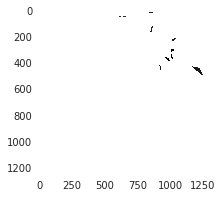

In [30]:
fig,ax = plt.subplots(1,figsize = (3,3))
ax.imshow(convert(cleftsA[0]),cmap=cm.Greys)

In [29]:
np.unique(convert(cleftsA[0]),return_counts=True)

(array([  0, 746, 754, 755, 756, 781, 788, 857, 858], dtype=uint64),
 array([1556765,     417,     602,     401,     422,     339,    1753,
            708,    1093]))

In [56]:
def calculate_range(data):
    uniqueseg = np.unique(convert(data))
    position = {}  # left,right,down,up
    for i in uniqueseg:
        if i !=0:
            xpos = np.where(data ==i)[0]
            ypos = np.where(data ==i)[1]
            position[i] = np.ndarray([4])
            down,up,lef,rig = np.min(xpos),np.max(xpos),np.min(ypos),np.max(ypos)
            position[i] = np.array([lef,rig,down,up])
    return position

In [57]:
dictest = calculate_range(convert(cleftsA[0]))

In [58]:
np.fromiter(dictest.keys(),dtype=int)

array([746, 754, 755, 756, 781, 788, 857, 858])

In [59]:
dictest[np.fromiter(dictest.keys(),dtype=int)[0]]

array([608, 661,  45,  56])

In [60]:
def get_central(pointdict):
    keys = np.fromiter(pointdict.keys(),dtype=int)
    central = np.ndarray([keys.shape[0],2])
    for i in range(keys.shape[0]):
        down,up,lef,rig = pointdict[keys[i]] 
        central[i] = np.array([(down+up)/2,(lef+rig)/2])
    return central

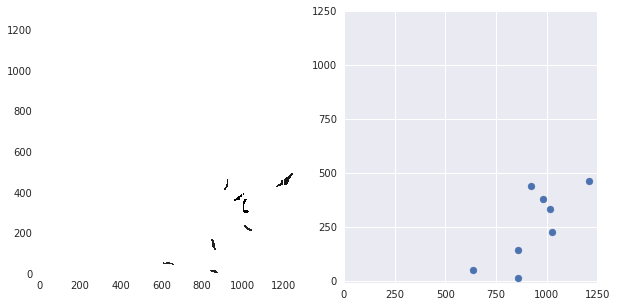

In [62]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(convert(cleftsA[0]) ,cmap=cm.Greys,origin='low')
ax[1].scatter(get_central(dictest)[:,0],get_central(dictest)[:,1],cmap=cm.Greys)
ax[1].set_xticks(np.arange(0,1500,250))
ax[1].set_yticks(np.arange(0,1500,250))

In [14]:
from skimage.morphology import convex_hull_object
test = convex_hull_object(convert(cleftsA[0]))

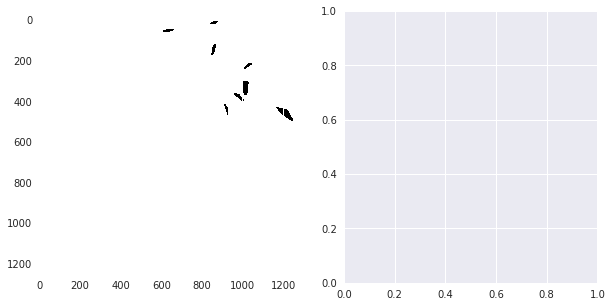

In [32]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(test ,cmap=cm.Greys)

## visualize partner

In [4]:
with h5py.File('data/public/sample_A_padded_20160501.hdf','r') as f:
    rawA = f['volumes/raw'][:]
    cleftsA = f['volumes/labels/clefts'][:]
    neuronidA = f['volumes/labels/neuron_ids'][:]
    annoidsA = f['annotations/ids'][:]
    locationA = f['annotations/locations'][:]
    presynapsesiteA = f['annotations/presynaptic_site/partners'][:]
    targetidA = f['annotations/comments/target_ids'][:]
    commentsA = f['annotations/comments/comments'][:]
    #print (list(f['annotations/presynaptic_site']))